<a href="https://colab.research.google.com/github/decile-team/submodlib/blob/master/tutorials/Different_Options_for_Usage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init

In [ ]:
import sklearn
sklearn.__version__

'0.22.2.post1'

In [ ]:
!pip uninstall scikit-learn -y

Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
!pip install -U scikit-learn

     |████████████████████████████████| 22.3MB 2.1MB/s 


In [ ]:
import sklearn
sklearn.__version__

'0.24.2'

In [ ]:
!pip install -i https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple/ submodlib

Looking in indexes: https://test.pypi.org/simple/, https://pypi.org/simple/
     |████████████████████████████████| 81kB 4.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for submodlib: filename=submodlib-1.1.1-cp37-cp37m-linux_x86_64.whl size=491341 sha256=880e8e02ee0cbffedc1e0b98c622d5746ceba3d5ce85bcac1a67df5b5e8a9829
  Stored in directory: /root/.cache/pip/wheels/b2/07/ad/7fa8ce6d1fb8bc1151f12e71d93890202d77825591285200a5
Successfully built submodlib


# Prepare Data

The first step in using submodlib is obviously to have some data at hand. Below we create a synthetic dataset of 500 points distributed across 10 clusters with a standard deviation of 4. In practice, each data point could correspond to images or video frames or any other dataset where subset selection is desired.

In [ ]:
from sklearn.datasets import make_blobs
num_clusters = 10
cluster_std_dev = 4
points, cluster_ids, centers = make_blobs(n_samples=500, centers=num_clusters, 
                                          n_features=2, cluster_std=cluster_std_dev, center_box=(0,100), 
                                          return_centers=True, random_state=4)
data = list(map(tuple, points))
xs = [x[0] for x in data]
ys = [x[1] for x in data]

# Visualize Data

The visualization of the generated sample data shows the data points and the clusters.

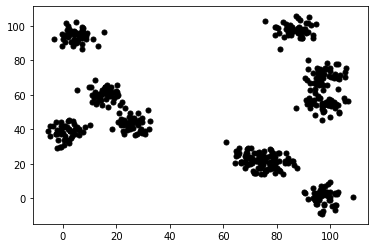

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(xs, ys, s=25, color='black', label="Images")

For demonstration, let us create two sample subsets of this dataset such that subset 1 consists of points from the same cluster and subset 2 consists of diverse points from different clusters. The subsets are shown by the red points in the below visualizations.

# Sample Subset 1

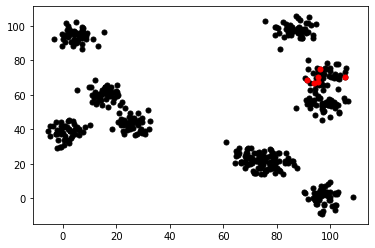

In [ ]:
# get 6 data points belonging to cluster#1
import random
random.seed(1)
cluster1Indices = [index for index, val in enumerate(cluster_ids) if val == 1]
subset1 = random.sample(cluster1Indices, 6)
subset1xs = [xs[x] for x in subset1]
subset1ys = [ys[x] for x in subset1]
plt.scatter(xs, ys, s=25, color='black', label="Images")
plt.scatter(subset1xs, subset1ys, s=25, color='red', label="Subset1")
set1 = set(subset1[:-1])

# Sample Subset 2

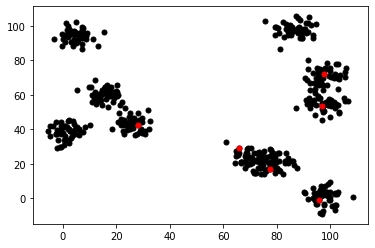

In [ ]:
# get 6 data points belonging to different clusters
subset2 = []
for i in range(6):
    #find the index of first point that belongs to cluster i
    diverse_index = cluster_ids.tolist().index(i)
    subset2.append(diverse_index)
subset2xs = [xs[x] for x in subset2]
subset2ys = [ys[x] for x in subset2]
plt.scatter(xs, ys, s=25, color='black', label="Images")
plt.scatter(subset2xs, subset2ys, s=25, color='red', label="Subset2")
set2 = set(subset2[:-1])

# Different Alternatives of Usage

Let us now use submodlib's [FacilityLocation](https://submodlib.readthedocs.io/en/latest/functions/facilityLocation.html) as an example to understand the basic usage of submodlib. Using a submodular function in submodlib essentially boils down to just two steps:
1. instantiate the corresponding function object
2. invoke the desired method on the created object (evaluate(), marginalGain(), maximize())

We will evaluate the scores of the two subsets just created. Since FacilityLocation models representation, we expect subset1's score to be less than subset2's score.

We also demonstrate one of the USPs of submodlib which is the degree of flexibility it offers in its usage. It provides different alternative ways of consumption based on user requirements and or scale/efficiency reasons. For example, we shall see below how Facility Location can be invoked in fllowing different ways:

1. Creating dense similarity kernel in C++: user only provides the data matrix and dense similarity kernel is internally created in C++ using user specified similarity metric
2. Creating dense similarity kernel in Python: user creates dense similarity kernel in Python (using submodlib's helper code) and uses that to instantiate FacilityLocation
3. For both of the above versions, user can opt for creating sparse similarity kernel (similarity with points beyond the num_neighbors is considered zero) as against dense similarity kernel (N X N). Sparse kernels tend to be more efficient, especially for large datasets, but at the cost of accuracy. 

In [ ]:
import numpy as np
dataArray = np.array(data)

In [ ]:
from submodlib.functions.facilityLocation import FacilityLocationFunction

## 1. Dense similarity kernel in C++

User only provides the data matrix, specifies the mode as "dense", the similarity metric to be used and the kernel is internally computed in C++ which is then used to instantiate the Facility Location object. Different functions can then be called on this object.The blue points in te below visualizations show the optimal subset of size 10 as a result of doing a naive greedy maximization of Facility Location over the groundset. As can be seen, the optimal subset contains points which are diverse and representative of the groundset.

Subset 1's FL value = 19.077501174346022
Subset 2's FL value = 33.40803109127237
Gain of adding another point (349) of same cluster to {418, 173, 81, 82, 62} = 0.9128064368493485
Gain of adding another point (5) of different cluster to {418, 173, 81, 82, 62} = 8.70453873069498
Subset 1's Fast FL value = 19.077501174346022
Fast gain of adding another point (349) of same cluster to {418, 173, 81, 82, 62} = 0.9128064368493485
Greedy vector: [(331, 11.15808445260569), (451, 10.472547392190126), (342, 10.236736534779283), (346, 10.19024820276536), (403, 9.907894771080464), (157, 9.54630041520151), (170, 9.379224710284689), (408, 8.46382283931598), (420, 8.064860103128012), (350, 6.62066416721791)]


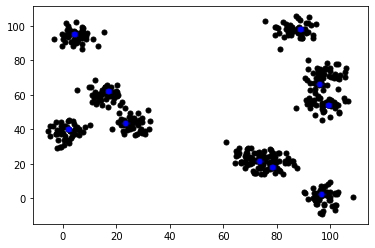

In [ ]:
#start = time.process_time()
obj1 = FacilityLocationFunction(n=500, mode="dense", data=dataArray, metric="euclidean")
#print(f"Time taken by instantiation = {time.process_time() - start}")
print(f"Subset 1's FL value = {obj1.evaluate(set1)}")
print(f"Subset 2's FL value = {obj1.evaluate(set2)}")
print(f"Gain of adding another point ({subset1[-1]}) of same cluster to {set1} = {obj1.marginalGain(set1, subset1[-1])}")
print(f"Gain of adding another point ({subset2[-1]}) of different cluster to {set1} = {obj1.marginalGain(set1, subset2[-1])}")
obj1.setMemoization(set1)
print(f"Subset 1's Fast FL value = {obj1.evaluateWithMemoization(set1)}")
print(f"Fast gain of adding another point ({subset1[-1]}) of same cluster to {set1} = {obj1.marginalGainWithMemoization(set1, subset1[-1])}")
#start = time.process_time()
greedyList = obj1.maximize(budget=10,optimizer='NaiveGreedy', stopIfZeroGain=False, stopIfNegativeGain=False, verbose=False)
#print(f"Time taken by maximization = {time.process_time() - start}")
print(f"Greedy vector: {greedyList}")
greedyXs = [xs[x[0]] for x in greedyList]
greedyYs = [ys[x[0]] for x in greedyList]
plt.scatter(xs, ys, s=25, color='black', label="Images")
plt.scatter(greedyXs, greedyYs, s=25, color='blue', label="Greedy Set")

## 2. Dense similarity kernel in Python

If dense similarity kernel is to be created in Python, the user may use the create_kernel() helper function provided by submodlib and pass the kernel as argument to Facility Location. Again, different functions can then be called on this object.The blue points in the below visualizations show the optimal subset of size 10 as a result of doing a naive greedy maximization of Facility Location over the groundset. As expected in the case of Facility Location, the optimal subset contains points which are diverse and representative of the groundset.

Subset 1's FL value = 19.077494220452813
Subset 2's FL value = 33.40803428527755
Gain of adding another point of same cluster (349) to {418, 173, 81, 82, 62} = 0.9128059695327785
Gain of adding another point of different cluster (5) to {418, 173, 81, 82, 62} = 8.704536034173348
Subset 1's Fast FL value = 19.077494220452813
Fast gain of adding another point (349) of same cluster to {418, 173, 81, 82, 62} = 0.9128059695327785
Greedy vector: [(331, 11.158085198505441), (451, 10.472547937009836), (342, 10.236736311430235), (346, 10.190245383419096), (403, 9.907896679127589), (157, 9.54630036071348), (170, 9.379225685164783), (408, 8.463821834884584), (420, 8.064858683210332), (350, 6.620665322523564)]


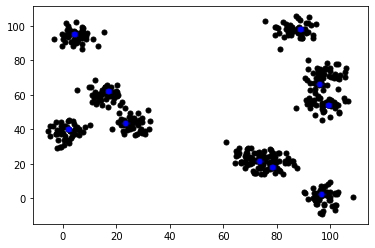

In [ ]:
from submodlib.helper import create_kernel
#start = time.process_time()
K_dense = create_kernel(dataArray, mode='dense',metric='euclidean')
obj2 = FacilityLocationFunction(n=500, mode="dense", sijs = K_dense, separate_rep=False)
#print(f"Time taken by instantiation = {time.process_time() - start}")
print(f"Subset 1's FL value = {obj2.evaluate(set1)}")
print(f"Subset 2's FL value = {obj2.evaluate(set2)}")
print(f"Gain of adding another point of same cluster ({subset1[-1]}) to {set1} = {obj2.marginalGain(set1, subset1[-1])}")
print(f"Gain of adding another point of different cluster ({subset2[-1]}) to {set1} = {obj2.marginalGain(set1, subset2[-1])}")
obj2.setMemoization(set1)
print(f"Subset 1's Fast FL value = {obj2.evaluateWithMemoization(set1)}")
print(f"Fast gain of adding another point ({subset1[-1]}) of same cluster to {set1} = {obj2.marginalGainWithMemoization(set1, subset1[-1])}")
#start = time.process_time()
greedyList = obj2.maximize(budget=10,optimizer='NaiveGreedy', stopIfZeroGain=False, stopIfNegativeGain=False, verbose=False)
#print(f"Time taken by maximization = {time.process_time() - start}")
print(f"Greedy vector: {greedyList}")
greedyXs = [xs[x[0]] for x in greedyList]
greedyYs = [ys[x[0]] for x in greedyList]
plt.scatter(xs, ys, s=25, color='black', label="Images")
plt.scatter(greedyXs, greedyYs, s=25, color='blue', label="Greedy Set")

## 3. More efficient, scalable sparse kernel alternatives for both flavors

This is achieved simply by changing the mode to "sparse" either in constructor of Facility Location (if sparse kernel is to be created in C++) or in create_kernel() (if sparse kernel is to be created in Python) and specifying the number of neighbors to be used for the creation of sparse kernel.

### a) Sparse similarity kernel creation in C++

Again, user only provides the data matrix, the appropriate parameters and submodlib takes care of the rest. As can be seen in the visualization below, the optimal subset is now not as representative as in the case of dense kernel.

Subset 1's FL value = 18.218661695718765
Subset 2's FL value = 22.534125223755836
Gain of adding another point (349) of same cluster to {418, 173, 81, 82, 62} = 1.0765964835882187
Gain of adding another point (5) of different cluster to {418, 173, 81, 82, 62} = 5.94344725087285
Subset 1's Fast FL value = 18.218661695718765
Fast gain of adding another point (349) of same cluster to {418, 173, 81, 82, 62} = 1.0765964835882187
Greedy vector: [(157, 8.216834783554077), (234, 7.679850354790688), (356, 7.368469715118408), (32, 7.337082579731941), (305, 7.316668227314949), (411, 6.9907707422971725), (49, 6.702258665114641), (81, 6.681817062199116), (196, 6.516425839625299), (492, 6.450755414552987)]


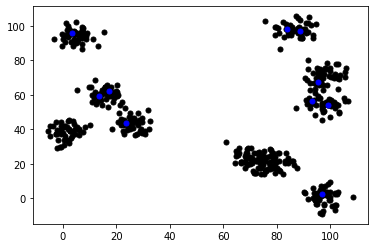

In [ ]:
#start = time.process_time()
obj3 = FacilityLocationFunction(n=500, data=dataArray, mode="sparse", metric="euclidean", num_neighbors=10)
#print(f"Time taken by instantiation = {time.process_time() - start}")
print(f"Subset 1's FL value = {obj3.evaluate(set1)}")
print(f"Subset 2's FL value = {obj3.evaluate(set2)}")
print(f"Gain of adding another point ({subset1[-1]}) of same cluster to {set1} = {obj3.marginalGain(set1, subset1[-1])}")
print(f"Gain of adding another point ({subset2[-1]}) of different cluster to {set1} = {obj3.marginalGain(set1, subset2[-1])}")
obj3.setMemoization(set1)
print(f"Subset 1's Fast FL value = {obj3.evaluateWithMemoization(set1)}")
print(f"Fast gain of adding another point ({subset1[-1]}) of same cluster to {set1} = {obj3.marginalGainWithMemoization(set1, subset1[-1])}")
#start = time.process_time()
greedyList = obj3.maximize(budget=10,optimizer='NaiveGreedy', stopIfZeroGain=False, stopIfNegativeGain=False, verbose=False)
#print(f"Time taken by maximization = {time.process_time() - start}")
print(f"Greedy vector: {greedyList}")
greedyXs = [xs[x[0]] for x in greedyList]
greedyYs = [ys[x[0]] for x in greedyList]
plt.scatter(xs, ys, s=25, color='black', label="Images")
plt.scatter(greedyXs, greedyYs, s=25, color='blue', label="Greedy Set")

### b) Sparse similarity kernel creation in Python

Like the dense kernel case, user invokes the create_kernel() helper function and specifies the mode to be "sparse" along with the number of nearest neighbors to be considered.

Subset 1's FL value = 18.218654844909906
Subset 2's FL value = 22.53413074091077
Gain of adding another point of same cluster (349) to {418, 173, 81, 82, 62} = 1.0765958279371262
Gain of adding another point of different cluster (5) to {418, 173, 81, 82, 62} = 5.943446192890406
Subset 1's Fast FL value = 18.218654844909906
Fast gain of adding another point (349) of same cluster to {418, 173, 81, 82, 62} = 1.0765958279371262
Greedy vector: [(157, 8.216834411025047), (234, 7.679846853017807), (356, 7.368470624089241), (32, 7.337081626057625), (305, 7.316667214035988), (411, 6.990770533680916), (49, 6.702257856726646), (81, 6.681814573705196), (196, 6.516426174901426), (492, 6.450754040852189)]


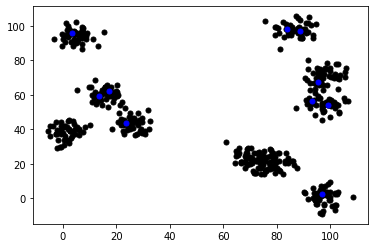

In [ ]:
#from submodlib.helper import create_kernel
#start = time.process_time()
K_sparse = create_kernel(dataArray, mode='sparse', metric='euclidean', num_neigh=10)
obj4 = FacilityLocationFunction(n=500, mode = "sparse", sijs = K_sparse, num_neighbors=10)
#print(f"Time taken by instantiation = {time.process_time() - start}")
print(f"Subset 1's FL value = {obj4.evaluate(set1)}")
print(f"Subset 2's FL value = {obj4.evaluate(set2)}")
print(f"Gain of adding another point of same cluster ({subset1[-1]}) to {set1} = {obj4.marginalGain(set1, subset1[-1])}")
print(f"Gain of adding another point of different cluster ({subset2[-1]}) to {set1} = {obj4.marginalGain(set1, subset2[-1])}")
obj4.setMemoization(set1)
print(f"Subset 1's Fast FL value = {obj4.evaluateWithMemoization(set1)}")
print(f"Fast gain of adding another point ({subset1[-1]}) of same cluster to {set1} = {obj4.marginalGainWithMemoization(set1, subset1[-1])}")
#start = time.process_time()
greedyList = obj4.maximize(budget=10,optimizer='NaiveGreedy', stopIfZeroGain=False, stopIfNegativeGain=False, verbose=False)
#print(f"Time taken by maximization = {time.process_time() - start}")
print(f"Greedy vector: {greedyList}")
greedyXs = [xs[x[0]] for x in greedyList]
greedyYs = [ys[x[0]] for x in greedyList]
plt.scatter(xs, ys, s=25, color='black', label="Images")
plt.scatter(greedyXs, greedyYs, s=25, color='blue', label="Greedy Set")

## Clustered Implementations

In addition to the above, as another alternative for efficient and scalable implementation and to provide for supervised subset selection, submodlib provides clustered implementation of various submodular functions. submodlib does this in two ways:
1. As yet another "mode" in the particular function - for example "clustered" mode in FacilityLocation over and above "dense" and "sparse" modes. See [FacilityLocation](https://submodlib.readthedocs.io/en/latest/functions/facilityLocation.html) for the math.
2. Through a generic Clustered Function implementation which works for any submodular function. See [ClusteredFunction](https://submodlib.readthedocs.io/en/latest/functions/clustered.html) for the math.

For both the alternatives, and in the spirit of giving flexibility, the user has choice to either a) let submodlib do the clustering internally or b) provide the clusters (for example in case of supervised subset selection).

### 1. Using "clustered" mode in FacilityLocation

#### a) submodlib creates clusters internally

User only provides the data matrix, sets the mode to "clustered" and provides the number of clusters. submodlib internally uses sklearn's [BIRCH](https://scikit-learn.org/stable/modules/clustering.html#birch) to do the clustering. An important point to note here is that the "metric" is not for clustering but for creating the required dense kernels for each cluster. 

Subset 1's FL value = 19.016476780641824
Subset 2's FL value = 32.67558133404236
Gain of adding another point (349) of same cluster to {418, 173, 81, 82, 62} = 0.8984317579306662
Gain of adding another point (5) of different cluster to {418, 173, 81, 82, 62} = 8.570448095910251
Subset 1's Fast FL value = 19.016476780641824
Fast gain of adding another point (349) of same cluster to {418, 173, 81, 82, 62} = 0.8984317579306662
Greedy vector: [(451, 10.472545809810981), (346, 10.190267061814666), (305, 10.160849837353453), (497, 10.061724217026494), (403, 9.93304333765991), (170, 9.379119548830204), (157, 9.106656132265925), (408, 8.46727136312984), (420, 8.218908534152433), (377, 6.971351287444122)]


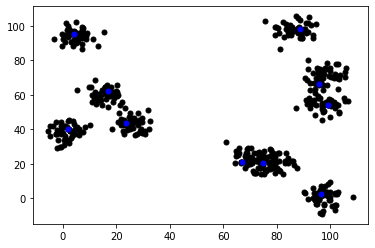

In [ ]:
#start = time.process_time()
obj5 = FacilityLocationFunction(n=500, data=dataArray, mode="clustered", metric="euclidean", num_clusters=10)
#print(f"Time taken by instantiation = {time.process_time() - start}")
print(f"Subset 1's FL value = {obj5.evaluate(set1)}")
print(f"Subset 2's FL value = {obj5.evaluate(set2)}")
print(f"Gain of adding another point ({subset1[-1]}) of same cluster to {set1} = {obj5.marginalGain(set1, subset1[-1])}")
print(f"Gain of adding another point ({subset2[-1]}) of different cluster to {set1} = {obj5.marginalGain(set1, subset2[-1])}")
obj5.setMemoization(set1)
print(f"Subset 1's Fast FL value = {obj5.evaluateWithMemoization(set1)}")
print(f"Fast gain of adding another point ({subset1[-1]}) of same cluster to {set1} = {obj5.marginalGainWithMemoization(set1, subset1[-1])}")
#start = time.process_time()
greedyList = obj5.maximize(budget=10,optimizer='NaiveGreedy', stopIfZeroGain=False, stopIfNegativeGain=False, verbose=False)
#print(f"Time taken by maximization = {time.process_time() - start}")
print(f"Greedy vector: {greedyList}")
greedyXs = [xs[x[0]] for x in greedyList]
greedyYs = [ys[x[0]] for x in greedyList]
plt.scatter(xs, ys, s=25, color='black', label="Images")
plt.scatter(greedyXs, greedyYs, s=25, color='blue', label="Greedy Set")

#### b) User provides clusters

Here user provides the clustering in form of the cluster labels for each data point. submodlib internally creates dense kernels per cluster based on the metric specified. 

Subset 1's FL value = 18.799584541469812
Subset 2's FL value = 33.28586935421481
Gain of adding another point (349) of same cluster to {418, 173, 81, 82, 62} = 0.8355859965085983
Gain of adding another point (5) of different cluster to {418, 173, 81, 82, 62} = 6.761740664485842
Subset 1's Fast FL value = 18.799584541469812
Fast gain of adding another point (349) of same cluster to {418, 173, 81, 82, 62} = 0.8355859965085983
Greedy vector: [(451, 10.472545809810981), (342, 10.212627607863396), (346, 10.190267061814666), (403, 9.928557990817353), (157, 9.506034689489752), (170, 9.379119548830204), (408, 8.46727136312984), (252, 7.982360491994768), (275, 7.918852358445292), (350, 7.2573228888213634)]


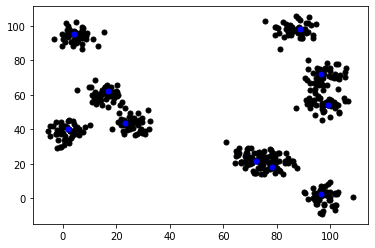

In [ ]:
#start = time.process_time()
obj6 = FacilityLocationFunction(n=500, data=dataArray, cluster_labels=cluster_ids.tolist(), mode="clustered", metric="euclidean", num_clusters=10)
#print(f"Time taken by instantiation = {time.process_time() - start}")
print(f"Subset 1's FL value = {obj6.evaluate(set1)}")
print(f"Subset 2's FL value = {obj6.evaluate(set2)}")
print(f"Gain of adding another point ({subset1[-1]}) of same cluster to {set1} = {obj6.marginalGain(set1, subset1[-1])}")
print(f"Gain of adding another point ({subset2[-1]}) of different cluster to {set1} = {obj6.marginalGain(set1, subset2[-1])}")
obj6.setMemoization(set1)
print(f"Subset 1's Fast FL value = {obj6.evaluateWithMemoization(set1)}")
print(f"Fast gain of adding another point ({subset1[-1]}) of same cluster to {set1} = {obj6.marginalGainWithMemoization(set1, subset1[-1])}")
#start = time.process_time()
greedyList = obj6.maximize(budget=10,optimizer='NaiveGreedy', stopIfZeroGain=False, stopIfNegativeGain=False, verbose=False)
#print(f"Time taken by maximization = {time.process_time() - start}")
print(f"Greedy vector: {greedyList}")
greedyXs = [xs[x[0]] for x in greedyList]
greedyYs = [ys[x[0]] for x in greedyList]
plt.scatter(xs, ys, s=25, color='black', label="Images")
plt.scatter(greedyXs, greedyYs, s=25, color='blue', label="Greedy Set")

### 2. Using ClusteredFunction

This is an alternative way of invoking the clustered implementation of a submodular function and is more generic in its handling of different functions.

In [ ]:
from submodlib import ClusteredFunction

#### a) submodlib creates clusters internally, implementation creates and uses multiple small kernels

Same as 1a) above, user only provides the data matrix, provides the number of clusters and submodlib does the rest.

Subset 1's FL value = 19.016476780641824
Subset 2's FL value = 32.67558133404236
Gain of adding another point (349) of same cluster to {418, 173, 81, 82, 62} = 0.8984317579306662
Gain of adding another point (5) of different cluster to {418, 173, 81, 82, 62} = 8.570448095910251
Subset 1's Fast FL value = 19.016476780641824
Fast gain of adding another point (349) of same cluster to {418, 173, 81, 82, 62} = 0.8984317579306662
Greedy vector: [(451, 10.472545809810981), (346, 10.190267061814666), (305, 10.160849837353453), (497, 10.061724217026494), (403, 9.93304333765991), (170, 9.379119548830204), (157, 9.106656132265925), (408, 8.46727136312984), (420, 8.218908534152433), (377, 6.971351287444122)]


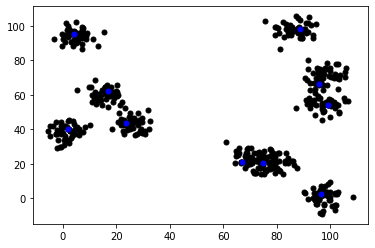

In [ ]:
#start = time.process_time()
obj7 = ClusteredFunction(n=500, mode="multi", f_name='FacilityLocation', metric='euclidean', data=dataArray, num_clusters=10)
#print(f"Time taken by instantiation = {time.process_time() - start}")
print(f"Subset 1's FL value = {obj7.evaluate(set1)}")
print(f"Subset 2's FL value = {obj7.evaluate(set2)}")
print(f"Gain of adding another point ({subset1[-1]}) of same cluster to {set1} = {obj7.marginalGain(set1, subset1[-1])}")
print(f"Gain of adding another point ({subset2[-1]}) of different cluster to {set1} = {obj7.marginalGain(set1, subset2[-1])}")
obj7.setMemoization(set1)
print(f"Subset 1's Fast FL value = {obj7.evaluateWithMemoization(set1)}")
print(f"Fast gain of adding another point ({subset1[-1]}) of same cluster to {set1} = {obj7.marginalGainWithMemoization(set1, subset1[-1])}")
#start = time.process_time()
greedyList = obj7.maximize(budget=10,optimizer='NaiveGreedy', stopIfZeroGain=False, stopIfNegativeGain=False, verbose=False)
#print(f"Time taken by maximization = {time.process_time() - start}")
print(f"Greedy vector: {greedyList}")
greedyXs = [xs[x[0]] for x in greedyList]
greedyYs = [ys[x[0]] for x in greedyList]
plt.scatter(xs, ys, s=25, color='black', label="Images")
plt.scatter(greedyXs, greedyYs, s=25, color='blue', label="Greedy Set")

#### b) User provides clusters, implementation creates and uses multiple small kernels

Similar to 1b above where in addition to the above parameters, user provides the clustering information as well to the constructor of Clustered Function. submodlib internally creates dense kernels per cluster based on the metric specified.

Subset 1's FL value = 18.799584541469812
Subset 2's FL value = 33.28586935421481
Gain of adding another point (349) of same cluster to {418, 173, 81, 82, 62} = 0.8355859965085983
Gain of adding another point (5) of different cluster to {418, 173, 81, 82, 62} = 6.761740664485842
Subset 1's Fast FL value = 18.799584541469812
Fast gain of adding another point (349) of same cluster to {418, 173, 81, 82, 62} = 0.8355859965085983
Greedy vector: [(451, 10.472545809810981), (342, 10.212627607863396), (346, 10.190267061814666), (403, 9.928557990817353), (157, 9.506034689489752), (170, 9.379119548830204), (408, 8.46727136312984), (252, 7.982360491994768), (275, 7.918852358445292), (350, 7.2573228888213634)]


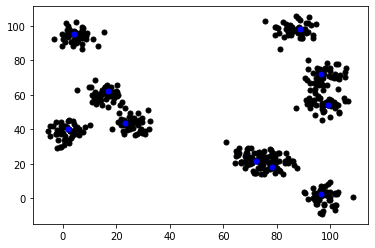

In [ ]:
#start = time.process_time()
obj8 = ClusteredFunction(n=500, f_name='FacilityLocation', mode="multi", metric='euclidean', data=dataArray, cluster_lab=cluster_ids.tolist(), num_clusters=10)
#print(f"Time taken by instantiation = {time.process_time() - start}")
print(f"Subset 1's FL value = {obj8.evaluate(set1)}")
print(f"Subset 2's FL value = {obj8.evaluate(set2)}")
print(f"Gain of adding another point ({subset1[-1]}) of same cluster to {set1} = {obj8.marginalGain(set1, subset1[-1])}")
print(f"Gain of adding another point ({subset2[-1]}) of different cluster to {set1} = {obj8.marginalGain(set1, subset2[-1])}")
obj8.setMemoization(set1)
print(f"Subset 1's Fast FL value = {obj8.evaluateWithMemoization(set1)}")
print(f"Fast gain of adding another point ({subset1[-1]}) of same cluster to {set1} = {obj8.marginalGainWithMemoization(set1, subset1[-1])}")
#start = time.process_time()
greedyList = obj8.maximize(budget=10,optimizer='NaiveGreedy', stopIfZeroGain=False, stopIfNegativeGain=False, verbose=False)
#print(f"Time taken by maximization = {time.process_time() - start}")
print(f"Greedy vector: {greedyList}")
greedyXs = [xs[x[0]] for x in greedyList]
greedyYs = [ys[x[0]] for x in greedyList]
plt.scatter(xs, ys, s=25, color='black', label="Images")
plt.scatter(greedyXs, greedyYs, s=25, color='blue', label="Greedy Set")

#### c) submodlib creates clusters internally, implementation creates and uses one big kernel

Same as 2a) above, user only provides the data matrix, provides the number of clusters and submodlib does the rest. However instead of creating a kernel per cluster, it creates one big kernel

Subset 1's FL value = 19.016483714804053
Subset 2's FL value = 32.67557819021749
Gain of adding another point (349) of same cluster to {418, 173, 81, 82, 62} = 0.8984322403557599
Gain of adding another point (5) of different cluster to {418, 173, 81, 82, 62} = 8.570450668688864
Subset 1's Fast FL value = 19.016483714804053
Fast gain of adding another point (349) of same cluster to {418, 173, 81, 82, 62} = 0.8984322403557599
Greedy vector: [(451, 10.472545264987275), (346, 10.19026988116093), (305, 10.160850205924362), (497, 10.061725384672172), (403, 9.933041419484653), (170, 9.379118573910091), (157, 9.106656576041132), (408, 8.467272366629913), (420, 8.218910050462), (377, 6.971351797808893)]


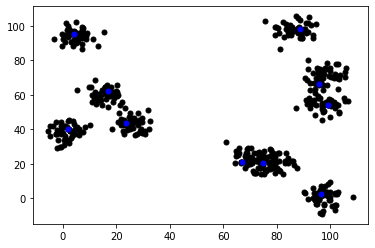

In [ ]:
#start = time.process_time()
obj9 = ClusteredFunction(n=500, mode="single", f_name='FacilityLocation', metric='euclidean', data=dataArray, num_clusters=10)
#print(f"Time taken by instantiation = {time.process_time() - start}")
print(f"Subset 1's FL value = {obj9.evaluate(set1)}")
print(f"Subset 2's FL value = {obj9.evaluate(set2)}")
print(f"Gain of adding another point ({subset1[-1]}) of same cluster to {set1} = {obj9.marginalGain(set1, subset1[-1])}")
print(f"Gain of adding another point ({subset2[-1]}) of different cluster to {set1} = {obj9.marginalGain(set1, subset2[-1])}")
obj9.setMemoization(set1)
print(f"Subset 1's Fast FL value = {obj9.evaluateWithMemoization(set1)}")
print(f"Fast gain of adding another point ({subset1[-1]}) of same cluster to {set1} = {obj9.marginalGainWithMemoization(set1, subset1[-1])}")
#start = time.process_time()
greedyList = obj9.maximize(budget=10,optimizer='NaiveGreedy', stopIfZeroGain=False, stopIfNegativeGain=False, verbose=False)
#print(f"Time taken by maximization = {time.process_time() - start}")
print(f"Greedy vector: {greedyList}")
greedyXs = [xs[x[0]] for x in greedyList]
greedyYs = [ys[x[0]] for x in greedyList]
plt.scatter(xs, ys, s=25, color='black', label="Images")
plt.scatter(greedyXs, greedyYs, s=25, color='blue', label="Greedy Set")

#### d) User provides clusters, implementation creates and uses one big kernel

Similar to 2b above where in addition to the above parameters, user provides the clustering information as well to the constructor of Clustered Function. submodlib internally creates one big kernel based on the metric provided

Subset 1's FL value = 18.799591479822993
Subset 2's FL value = 33.2858663088482
Gain of adding another point (349) of same cluster to {418, 173, 81, 82, 62} = 0.8355865776538849
Gain of adding another point (5) of different cluster to {418, 173, 81, 82, 62} = 6.76174206379801
Subset 1's Fast FL value = 18.799591479822993
Fast gain of adding another point (349) of same cluster to {418, 173, 81, 82, 62} = 0.8355865776538849
Greedy vector: [(451, 10.472545264987275), (342, 10.212627839995548), (346, 10.19026988116093), (403, 9.92855607252568), (157, 9.506034769117832), (170, 9.379118573910091), (408, 8.467272366629913), (252, 7.982360699214041), (275, 7.918852384056663), (350, 7.257323008030653)]


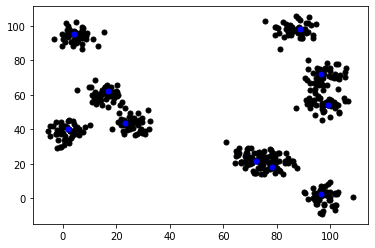

In [ ]:
#start = time.process_time()
obj10 = ClusteredFunction(n=500, f_name='FacilityLocation', mode="single", metric='euclidean', data=dataArray, cluster_lab=cluster_ids.tolist(), num_clusters=10)
#print(f"Time taken by instantiation = {time.process_time() - start}")
print(f"Subset 1's FL value = {obj10.evaluate(set1)}")
print(f"Subset 2's FL value = {obj10.evaluate(set2)}")
print(f"Gain of adding another point ({subset1[-1]}) of same cluster to {set1} = {obj10.marginalGain(set1, subset1[-1])}")
print(f"Gain of adding another point ({subset2[-1]}) of different cluster to {set1} = {obj10.marginalGain(set1, subset2[-1])}")
obj10.setMemoization(set1)
print(f"Subset 1's Fast FL value = {obj10.evaluateWithMemoization(set1)}")
print(f"Fast gain of adding another point ({subset1[-1]}) of same cluster to {set1} = {obj10.marginalGainWithMemoization(set1, subset1[-1])}")
#start = time.process_time()
greedyList = obj10.maximize(budget=10,optimizer='NaiveGreedy', stopIfZeroGain=False, stopIfNegativeGain=False, verbose=False)
#print(f"Time taken by maximization = {time.process_time() - start}")
print(f"Greedy vector: {greedyList}")
greedyXs = [xs[x[0]] for x in greedyList]
greedyYs = [ys[x[0]] for x in greedyList]
plt.scatter(xs, ys, s=25, color='black', label="Images")
plt.scatter(greedyXs, greedyYs, s=25, color='blue', label="Greedy Set")